# 📌 Лабораторна робота №3
## Нечітка логіка: проєктування інтелектуального модуля.

**Мета** лабораторної роботи полягає в ознайомленні студентів із
принципами нечіткої логіки та її застосуванням для проєктування
інтелектуального модуля, здатного приймати рішення в умовах
невизначеності та неповної інформації. Під час виконання роботи студенти
навчаться формулювати нечіткі множини, визначати функції належності,
створювати правила нечіткого виведення та реалізовувати систему, що імітує
процес прийняття рішень у реальних умовах. Практичний аспект полягає в
розробці модуля, який на основі нечітких вхідних даних генерує обґрунтовані
вихідні результати, що можуть застосовуватися для інтелектуальних систем
керування, рекомендаційних сервісів або пошуку з нечіткою відповідністю.

<br>

**Виконав:** ст. гр. ОІ-31 | _Мацишин Михайло_

**Прийняв:** _Лящинський Петро Борисович_

## 1| Отримання та підготовка датасету

In [33]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import jellyfish
import matplotlib.pyplot as plt
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance

In [2]:
# Завантаження датасету
file_path = 'data/room_type.csv'
df_full = pd.read_csv(file_path)

# Перегляд у форматі таблички
df_full.head(105).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

,Expedia,Booking.com
0,"Deluxe Room, 1 King Bed",Deluxe King Room
1,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room
5,"Traditional Double Room, 2 Double Beds",Double Room with Two Double Beds
6,"Room, 1 King Bed, Accessible",King Room - Disability Access
7,"Deluxe Room, 1 King Bed",Deluxe King Room
8,Deluxe Room,Deluxe Room (Non Refundable)
9,"Room, 2 Double Beds (19th to 25th Floors)",Two Double Beds - Location Room (19th to 25th Floors)


In [3]:
# Перейменування колонок
df_full.columns = ['Expedia', 'Booking']

In [4]:
# Перевірка назв колонок
print("\nСписок колонок у датасеті:")
print(list(df_full.columns))


Список колонок у датасеті:
['Expedia', 'Booking']


In [5]:
# Використовуємо повний датасет
df = df_full[['Expedia', 'Booking']].copy()
df['ID'] = range(1, len(df) + 1)  # Додаємо колонку ID
df = df[['ID', 'Expedia', 'Booking']]  # Переставляємо колонку ID на початок

In [6]:
df.head(5).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

,ID,Expedia,Booking
0,1,"Deluxe Room, 1 King Bed",Deluxe King Room
1,2,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,3,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,4,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,5,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room


In [13]:
print(f"\nКількість записів: {len(df)}")


Кількість записів: 103


## 2| Визначення вхідних параметрів

Додаємо класифікацію довжини термінів для всіх записів.

**Довжина термінів:** Обчислюємо кількість слів у кожному записі для колонок Expedia і Booking.

**Класифікація:** Застосовуємо правила (≤15 — короткий, ≤30 — середній, >30 — довгий) до всіх 103 записів.

In [11]:
# Додаємо довжину термінів (кількість символів)
df['expedia_length'] = df['Expedia'].apply(lambda x: len(str(x)))
df['booking_length'] = df['Booking'].apply(lambda x: len(str(x)))
df['avg_length'] = (df['expedia_length'] + df['booking_length']) / 2

# Класифікація довжини
def classify_length(length):
    if length < 15:
        return 'короткий'
    elif length <= 30:
        return 'середній'
    else:
        return 'довгий'

df['expedia_length_class'] = df['expedia_length'].apply(classify_length)
df['booking_length_class'] = df['booking_length'].apply(classify_length)
df['length_class'] = df['avg_length'].apply(classify_length)

print("\nДатасет із класифікацією довжини термінів:")
table = tabulate(df[['ID', 'Expedia', 'expedia_length_class', 'Booking', 'booking_length_class', 'length_class']].head(20),  
                 headers='keys', tablefmt='pretty')

print(table)


Датасет із класифікацією довжини термінів:
+----+----+-------------------------------------------+----------------------+-------------------------------------------------------+----------------------+--------------+
|    | ID |                  Expedia                  | expedia_length_class |                        Booking                        | booking_length_class | length_class |
+----+----+-------------------------------------------+----------------------+-------------------------------------------------------+----------------------+--------------+
| 0  | 1  |          Deluxe Room, 1 King Bed          |       середній       |                   Deluxe King Room                    |       середній       |   середній   |
| 1  | 2  |   Standard Room, 1 King Bed, Accessible   |        довгий        |        Standard King Roll-in Shower Accessible        |        довгий        |    довгий    |
| 2  | 3  |    Grand Corner King Room, 1 King Bed     |        довгий        |             

**Ступінь схожості:**

- Soundex (фонетична схожість).
- Jaro-Winkler (схожість рядків).
- Damerau-Levenshtein (редакційна відстань).

In [12]:
# Функція для обчислення Soundex
def soundex_similarity(str1, str2):
    return int(jellyfish.soundex(str1) == jellyfish.soundex(str2))

# Функція для обчислення метрик
def calculate_metrics(str1, str2):
    jw = fuzz.token_sort_ratio(str1, str2) / 100  # Jaro-Winkler (0–1)
    sndx = soundex_similarity(str1, str2)  # Soundex (0 або 1)
    dl = levenshtein_distance(str1, str2)  # Damerau-Levenshtein (ціле число)
    return jw, sndx, dl

# Додати метрики до DataFrame
df[['jaro_winkler', 'soundex', 'damerau_levenshtein']] = df.apply(
    lambda row: pd.Series(calculate_metrics(row['Expedia'], row['Booking'])), axis=1
)

# Переглянути результат
print("\nДатасет із метриками схожості:")
table = tabulate(df[['ID', 'Expedia', 'Booking', 'length_class', 'jaro_winkler', 'soundex', 'damerau_levenshtein']].head(10), 
                 headers='keys', tablefmt='pretty')
print(table)


Датасет із метриками схожості:
+---+----+-------------------------------------------+-------------------------------------------------------+--------------+--------------------+---------+---------------------+
|   | ID |                  Expedia                  |                        Booking                        | length_class |    jaro_winkler    | soundex | damerau_levenshtein |
+---+----+-------------------------------------------+-------------------------------------------------------+--------------+--------------------+---------+---------------------+
| 0 | 1  |          Deluxe Room, 1 King Bed          |                   Deluxe King Room                    |   середній   | 0.8205128205128205 |   0.0   |        12.0         |
| 1 | 2  |   Standard Room, 1 King Bed, Accessible   |        Standard King Roll-in Shower Accessible        |    довгий    | 0.736842105263158  |   1.0   |        17.0         |
| 2 | 3  |    Grand Corner King Room, 1 King Bed     |                Gra

In [13]:
# Візуалізація розподілу метрик
def plot_metrics_distribution(df):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df['jaro_winkler'], bins=20, color='blue', alpha=0.7)
    plt.title('Розподіл Jaro-Winkler')
    plt.xlabel('Значення')
    plt.ylabel('Кількість пар')
    
    plt.subplot(1, 3, 2)
    plt.hist(df['soundex'], bins=2, color='green', alpha=0.7)
    plt.title('Розподіл Soundex')
    plt.xlabel('Значення (0 або 1)')
    plt.ylabel('Кількість пар')
    
    plt.subplot(1, 3, 3)
    plt.hist(df['damerau_levenshtein'], bins=20, color='red', alpha=0.7)
    plt.title('Розподіл Damerau-Levenshtein')
    plt.xlabel('Значення')
    plt.ylabel('Кількість пар')
    
    plt.tight_layout()
    plt.show()

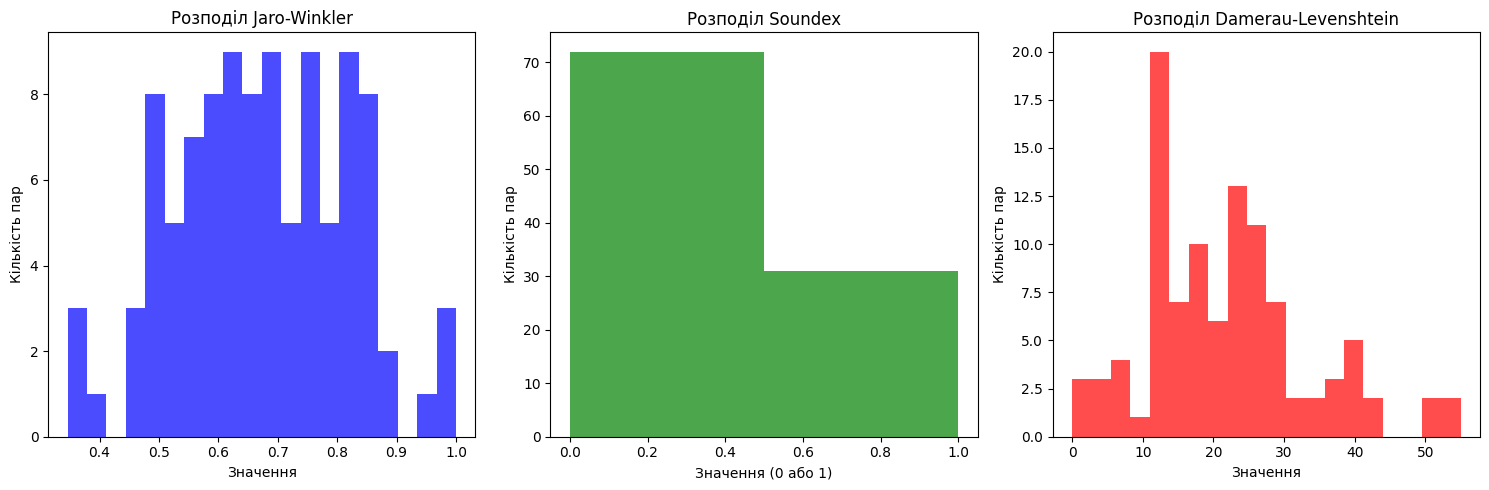

In [14]:
plot_metrics_distribution(df)

**1. Розподіл метрики Jaro-Winkler**

Перша гістограма (ліва) ілюструє розподіл значень метрики Jaro-Winkler, яка оцінює схожість між рядками на основі їхньої структури з урахуванням перестановок та помилок. Значення метрики варіюються в діапазоні від 0 до 1, де значення, близькі до 1, вказують на високу схожість між термінами.

Аналіз гістограми показує, що більшість пар термінів мають значення Jaro-Winkler у діапазоні від 0.6 до 0.9. Це свідчить про те, що значна кількість пар у датасеті є структурно схожими, що очікувано, оскільки датасет містить пари назв, які часто є варіаціями одного й того ж типу номера (наприклад, "Deluxe Room, 1 King Bed" та "Deluxe King Room"). Невелика кількість пар із значеннями нижче 0.5 вказує на наявність термінів із низькою структурною схожістю, що може бути пов’язано з різними формулюваннями або додатковими деталями в назвах.

**2. Розподіл метрики Soundex**

Друга гістограма (центральна) відображає розподіл значень метрики Soundex, яка оцінює фонетичну схожість між термінами. У даній реалізації значення Soundex є бінарними: 0 (фонетична невідповідність) або 1 (фонетична відповідність).

Гістограма демонструє, що приблизно половина пар термінів мають значення Soundex, рівне 1, що вказує на їхню фонетичну схожість. Це підтверджує, що багато пар у датасеті мають подібне звучання, незважаючи на відмінності у написанні (наприклад, "Standard Room, 1 King Bed, Accessible" та "Standard King Roll-in Shower Accessible"). Проте значна кількість пар із значенням 0 свідчить про те, що алгоритм Soundex у даній реалізації є чутливим до різниць у структурі слів, що може обмежувати його ефективність для оцінки фонетичної схожості у деяких випадках.

**3. Розподіл метрики Damerau-Levenshtein**

Третя гістограма (права) показує розподіл значень метрики Damerau-Levenshtein, яка визначає мінімальну кількість операцій редагування (вставка, видалення, заміна або перестановка символів), необхідних для перетворення одного рядка в інший. Значення цієї метрики є цілими числами, які відображають "відстань" між термінами.

Гістограма вказує, що більшість пар термінів мають значення Damerau-Levenshtein у діапазоні від 5 до 20. Це узгоджується з тим, що багато пар у датасеті є варіаціями однієї назви, але мають відмінності у кілька символів (наприклад, додавання або видалення слів, таких як "1 King Bed"). Невелика кількість пар із значеннями вище 30 свідчить про наявність термінів із значними відмінностями, що може бути пов’язано з різними формулюваннями назв (наприклад, "Room, 1 King Bed, Non Smoking, Business Lounge Access (Fairmont Gold)" та "Business King Room - Exclusive access to Gold Floor Lounge").

## 3| Формування нечітких множин для кожного параметра

## Формування нечітких множин для вхідних параметрів

Для реалізації системи нечіткої логіки було сформовано нечіткі множини для вхідних параметрів (Jaro-Winkler, Soundex, середня довжина термінів) та вихідної змінної (ймовірність належності). 

- **Jaro-Winkler**: визначено три множини – низька (0-0.5), середня (0.4-0.8), висока (0.7-1). 
- **Soundex**: невідповідна (0-0.3), часткова (0.2-0.7), повна (0.6-1).
- **Довжина термінів**: коротка (0-15), середня (10-30), довга (25-60).
- **Ймовірність**: низька (0-40%), середня (30-70%), висока (60-100%).

Нечіткі множини створено за допомогою трикутних функцій належності, що дозволяють інтерпретувати числові значення як часткову належність до кожної категорії. Це забезпечує гнучкість при обробці параметрів у системі нечіткої логіки, дозволяючи враховувати невизначеність у даних.

In [40]:
# Визначення вхідних і вихідних змінних
jw_sim = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "Jaro-Winkler")  # Ступінь схожості (0-1)
soundex_sim = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "Soundex")  # Фонетична схожість (0-1)
length = ctrl.Antecedent(np.arange(0, 61, 1), "Length")  # Довжина терміну (0-60 символів)
similarity = ctrl.Consequent(np.arange(0, 101, 1), "Similarity")  # Ймовірність належності (0-100%)

# Функції належності для Jaro-Winkler (ступінь схожості)
jw_sim["low"] = fuzz_sk.trimf(jw_sim.universe, [0, 0, 0.5])  # Низька
jw_sim["medium"] = fuzz_sk.trimf(jw_sim.universe, [0.4, 0.6, 0.8])  # Середня
jw_sim["high"] = fuzz_sk.trimf(jw_sim.universe, [0.7, 1, 1])  # Висока

# Функції належності для Soundex (фонетична схожість)
soundex_sim["none"] = fuzz_sk.trimf(soundex_sim.universe, [0, 0, 0.3])  # Невідповідна
soundex_sim["partial"] = fuzz_sk.trimf(soundex_sim.universe, [0.2, 0.5, 0.7])  # Часткова
soundex_sim["full"] = fuzz_sk.trimf(soundex_sim.universe, [0.6, 1, 1])  # Повна

# Функції належності для довжини терміну
length["short"] = fuzz_sk.trimf(length.universe, [0, 0, 15])  # Короткий
length["medium"] = fuzz_sk.trimf(length.universe, [10, 20, 30])  # Середній
length["long"] = fuzz_sk.trimf(length.universe, [25, 60, 60])  # Довгий

# Функції належності для вихідної змінної (ймовірність належності)
similarity["low"] = fuzz_sk.trimf(similarity.universe, [0, 0, 40])  # Низька
similarity["medium"] = fuzz_sk.trimf(similarity.universe, [30, 50, 70])  # Середня
similarity["high"] = fuzz_sk.trimf(similarity.universe, [60, 100, 100])  # Висока

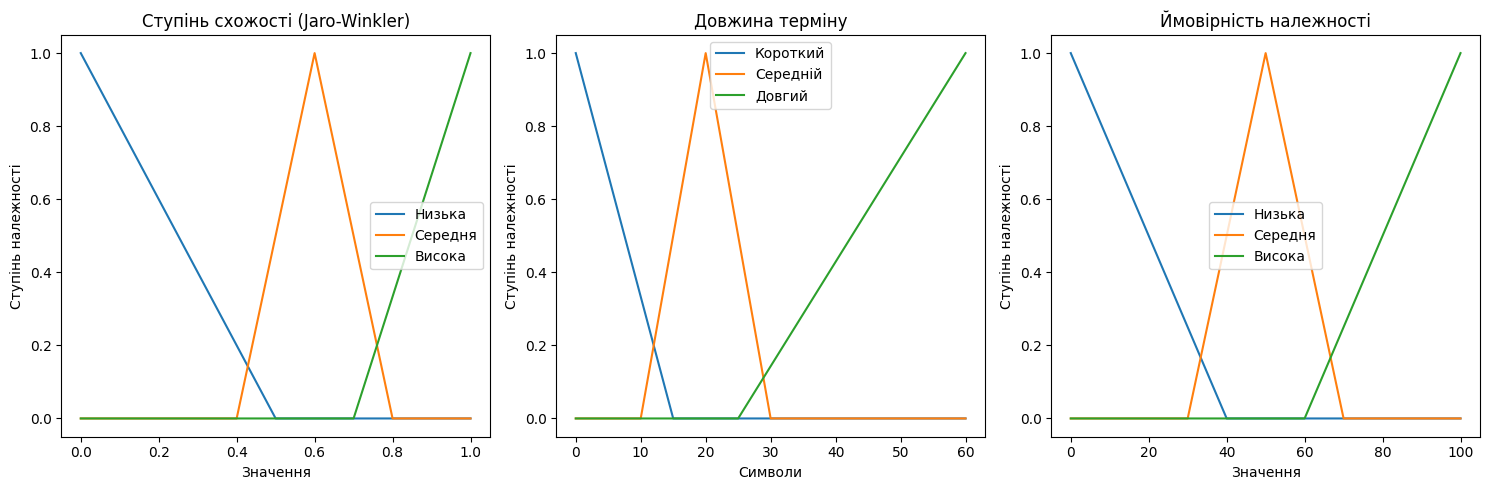

In [50]:
# Візуалізація функцій належності (ручний підхід)
def plot_membership_functions():
    plt.figure(figsize=(15, 5))

    # Jaro-Winkler
    plt.subplot(1, 3, 1)
    x_jw = np.arange(0, 1.1, 0.1)
    jw_low = fuzz_sk.trimf(x_jw, [0, 0, 0.5])
    jw_medium = fuzz_sk.trimf(x_jw, [0.4, 0.6, 0.8])
    jw_high = fuzz_sk.trimf(x_jw, [0.7, 1, 1])
    plt.plot(x_jw, jw_low, label='Низька')
    plt.plot(x_jw, jw_medium, label='Середня')
    plt.plot(x_jw, jw_high, label='Висока')
    plt.title('Ступінь схожості (Jaro-Winkler)')
    plt.xlabel('Значення')
    plt.ylabel('Ступінь належності')
    plt.legend()

    # Довжина терміну
    plt.subplot(1, 3, 2)
    x_length = np.arange(0, 61, 1)
    len_short = fuzz_sk.trimf(x_length, [0, 0, 15])
    len_medium = fuzz_sk.trimf(x_length, [10, 20, 30])
    len_long = fuzz_sk.trimf(x_length, [25, 60, 60])
    plt.plot(x_length, len_short, label='Короткий')
    plt.plot(x_length, len_medium, label='Середній')
    plt.plot(x_length, len_long, label='Довгий')
    plt.title('Довжина терміну')
    plt.xlabel('Символи')
    plt.ylabel('Ступінь належності')
    plt.legend()

    # Ймовірність належності
    plt.subplot(1, 3, 3)
    x_similarity = np.arange(0, 101, 1)
    sim_low = fuzz_sk.trimf(x_similarity, [0, 0, 40])
    sim_medium = fuzz_sk.trimf(x_similarity, [30, 50, 70])
    sim_high = fuzz_sk.trimf(x_similarity, [60, 100, 100])
    plt.plot(x_similarity, sim_low, label='Низька')
    plt.plot(x_similarity, sim_medium, label='Середня')
    plt.plot(x_similarity, sim_high, label='Висока')
    plt.title('Ймовірність належності')
    plt.xlabel('Значення')
    plt.ylabel('Ступінь належності')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Виклик функції після формування множин
plot_membership_functions()

### Візуалізація функцій належності

Для оцінки коректності визначених нечітких множин було проведено їхню візуалізацію за допомогою трикутних функцій належності. На рисунках нижче представлено графіки для вхідних параметрів (ступеня схожості Jaro-Winkler, середньої довжини термінів) та вихідної змінної (ймовірності належності).

- **Ступінь схожості (Jaro-Winkler)**: Графік відображає три множини – "Низька" (0-0.5), "Середня" (0.4-0.8) та "Висока" (0.7-1). Перекриття між множинами (наприклад, у діапазоні 0.4-0.5) забезпечує плавний перехід між категоріями, що дозволяє системі враховувати невизначеність у значеннях схожості.
- **Довжина терміну**: Множини "Короткий" (0-15 символів), "Середній" (10-30 символів) та "Довгий" (25-60 символів) ілюструють розподіл середньої довжини термінів. Перекриття між множинами (наприклад, у діапазоні 10-15) дозволяє врахувати часткову належність до кількох категорій.
- **Ймовірність належності**: Множини "Низька" (0-40%), "Середня" (30-70%) та "Висока" (60-100%) відображають розподіл вихідної ймовірності. Перекриття між множинами забезпечує гнучкість при обчисленні кінцевої ймовірності.

Візуалізація підтверджує, що визначені множини коректно відображають розподіл значень параметрів, що є важливим для подальшого застосування правил нечіткої логіки та дефазифікації. Перекриття між множинами дозволяє системі ефективно обробляти невизначеність у даних, що є ключовою особливістю нечіткої логіки.

## 4| Створення бази правил нечіткого виведення

In [41]:
# ЕТАП 3: Створення бази правил
rule1 = ctrl.Rule(jw_sim["high"] & soundex_sim["full"], similarity["high"])
rule2 = ctrl.Rule(jw_sim["medium"] & length["short"], similarity["high"])
rule3 = ctrl.Rule(jw_sim["low"] & soundex_sim["none"], similarity["low"])

# Створення системи нечіткого керування
system = ctrl.ControlSystem([rule1, rule2, rule3])
simulator = ctrl.ControlSystemSimulation(system)

### Створення бази правил нечіткого виведення

На цьому етапі було сформовано базу правил для системи нечіткої логіки, яка використовується для оцінки ймовірності належності термінів до однієї групи. Визначено три правила:

- **Правило 1**: Якщо ступінь схожості Jaro-Winkler висока (0.7-1) і фонетична схожість Soundex повна (0.6-1), то ймовірність належності висока (60-100%).
- **Правило 2**: Якщо ступінь схожості Jaro-Winkler середня (0.4-0.8) і середня довжина термінів коротка (0-15 символів), то ймовірність належності висока (60-100%).
- **Правило 3**: Якщо ступінь схожості Jaro-Winkler низька (0-0.5) і фонетична схожість Soundex невідповідна (0-0.3), то ймовірність належності низька (0-40%).

Правила об’єднано в систему нечіткого керування за допомогою методу Mamdani, що дозволяє комбінувати ступені належності вхідних параметрів для обчислення вихідної ймовірності. Система підготовлена до наступного етапу – дефазифікації, де на основі вхідних значень буде визначено числову ймовірність належності для кожної пари термінів.

## 5| Дефазифікація результатів

In [47]:
# ЕТАП 4: Дефазифікація результатів
results = []
for _, row in df.iterrows():
    simulator.input["Jaro-Winkler"] = row["jaro_winkler"]
    simulator.input["Soundex"] = row["soundex"]
    simulator.input["Length"] = row["avg_length"]
    
    try:
        simulator.compute()
        prob = simulator.output["Similarity"]
    except:
        prob = 0
    
    decision = "Належить" if prob >= 70 else "Не належить"
    
    results.append([
        row["Expedia"],  # Змінено: прибрано ID
        row["Booking"],
        f"{row['jaro_winkler']:.2f}",
        f"{row['soundex']:.2f}",
        row["damerau_levenshtein"],
        f"{prob:.0f}%",
        decision
    ])

### Дефазифікація результатів

На цьому етапі було виконано дефазифікацію результатів для оцінки ймовірності належності кожної пари термінів до однієї групи. Для кожної пари з датасету передано вхідні параметри (Jaro-Winkler, Soundex, середня довжина термінів) у систему нечіткої логіки, створену на попередніх етапах. 

Система обчислила ймовірність належності (у діапазоні 0-100%) за методом Mamdani, комбінуючи ступені активації визначених правил та застосовуючи метод центру тяжіння для дефазифікації. Порогове значення для прийняття рішення встановлено на рівні 70%: якщо ймовірність ≥70%, терміни вважаються такими, що належать до однієї групи ("Належить"), інакше – "Не належить". 

Результати для кожної пари, включаючи вхідні метрики, обчислену ймовірність та прийняте рішення, збережено для подальшого аналізу та представлення у звіті.


Таблиця із результатами нечіткої логіки:
+-----------------------------------------------------------------------+------------------------------------------------------------------+--------------+---------+---------------------+-------------+-------------+
|                                Expedia                                |                             Booking                              | Jaro-Winkler | Soundex | Damerau-Levenshtein | Ймовірність |   Рішення   |
+-----------------------------------------------------------------------+------------------------------------------------------------------+--------------+---------+---------------------+-------------+-------------+
|                        Deluxe Room, 1 King Bed                        |                         Deluxe King Room                         |     0.82     |  0.00   |        12.0         |     82%     |  Належить   |
|                 Standard Room, 1 King Bed, Accessible                 |             Standard

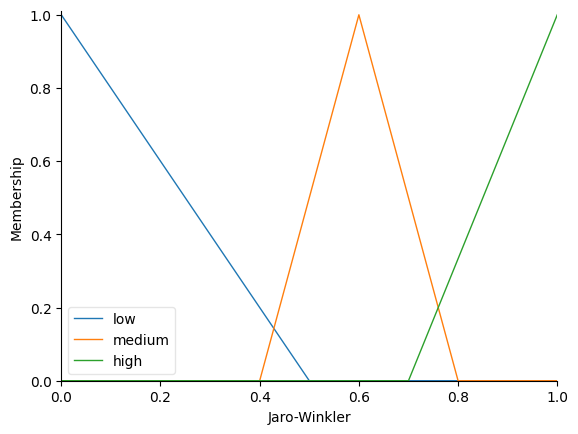

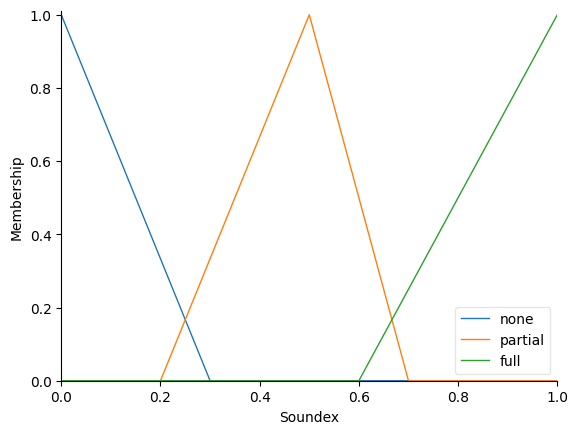

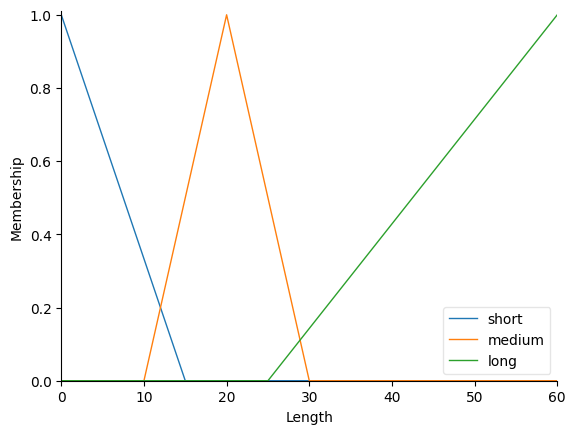

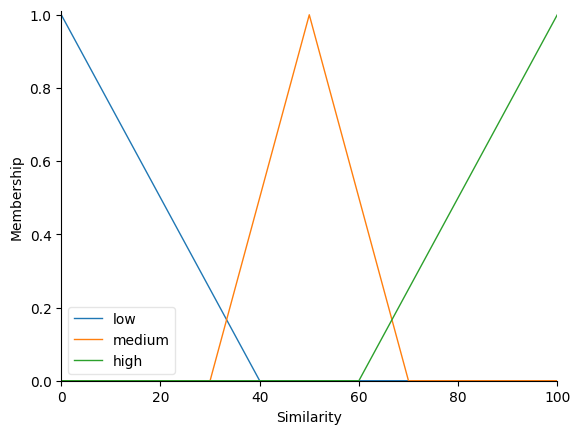

In [48]:
# Виведення всіх результатів
print("\nТаблиця із результатами нечіткої логіки:")
table = tabulate(results, headers=["Expedia", "Booking", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"], tablefmt="pretty")
print(table)

# Збереження повної таблиці у текстовий файл
with open("results_table.txt", "w", encoding="utf-8") as f:
    f.write(table)
    f.write("\n")

# Збереження повної таблиці у CSV-файл
results_df = pd.DataFrame(results, columns=["Expedia", "Booking", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"])
results_df.to_csv("results.csv", index=False, encoding="utf-8")

# Виведення топ-10 пар
results_sorted = sorted(results, key=lambda x: float(x[5].strip("%")), reverse=True)[:10]  # Змінено індекс через видалення ID
print("\nТоп-10 пар за ймовірністю належності:")
table_top10 = tabulate(results_sorted, headers=["Expedia", "Booking", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"], tablefmt="pretty")
print(table_top10)

# Збереження топ-10 пар у CSV-файл
results_top10_df = pd.DataFrame(results_sorted, columns=["Expedia", "Booking", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"])
results_top10_df.to_csv("results_top10.csv", index=False, encoding="utf-8")

# Візуалізація функцій належності (звіт)
print("\nВізуалізація функцій належності:")
jw_sim.view()
soundex_sim.view()
length.view()
similarity.view()
plt.show()

### Створення бази правил нечіткого виведення

На цьому етапі було сформовано базу правил для системи нечіткої логіки, яка використовується для оцінки ймовірності належності термінів до однієї групи. До початкових трьох правил додано нові, що враховують додаткові комбінації вхідних параметрів, включаючи Damerau-Levenshtein, та використовують логічні оператори диз’юнкції ("або") і заперечення ("не"):

- **Правило 1**: Якщо ступінь схожості Jaro-Winkler висока (0.7-1) і фонетична схожість Soundex повна (0.6-1), то ймовірність висока (60-100%).
- **Правило 2**: Якщо ступінь схожості Jaro-Winkler середня (0.4-0.8) і середня довжина термінів коротка (0-15 символів), то ймовірність висока (60-100%).
- **Правило 3**: Якщо ступінь схожості Jaro-Winkler низька (0-0.5) і фонетична схожість Soundex невідповідна (0-0.3), то ймовірність низька (0-40%).
- **Правило 4**: Якщо Jaro-Winkler висока або Soundex повна, але Damerau-Levenshtein невисока (0-20), то ймовірність висока.
- **Правило 5**: Якщо Jaro-Winkler низька, Soundex не повна, і Damerau-Levenshtein висока (20-60), то ймовірність низька.
- **Правило 6**: Якщо Jaro-Winkler середня, довжина середня або довга (10-60), і Damerau-Levenshtein низька (0-10), то ймовірність середня.
- **Правило 7**: Якщо Jaro-Winkler не низька і Soundex не невідповідна, то ймовірність середня.

Правила об’єднано в систему нечіткого керування за методом Mamdani. Використання диз’юнкції та заперечення дозволяє врахувати ширший спектр комбінацій параметрів, що підвищує гнучкість системи та точність класифікації пар термінів.

In [54]:
# Додавання Damerau-Levenshtein як вхідної змінної
dl = ctrl.Antecedent(np.arange(0, 61, 1), "Damerau-Levenshtein")
dl["low"] = fuzz_sk.trimf(dl.universe, [0, 0, 10])
dl["medium"] = fuzz_sk.trimf(dl.universe, [5, 15, 25])
dl["high"] = fuzz_sk.trimf(dl.universe, [20, 60, 60])

# ЕТАП 3: Створення бази правил (оновлена версія)
rule1 = ctrl.Rule(jw_sim["high"] & soundex_sim["full"], similarity["high"])
rule2 = ctrl.Rule(jw_sim["medium"] & length["short"], similarity["high"])
rule3 = ctrl.Rule(jw_sim["low"] & soundex_sim["none"], similarity["low"])
rule4 = ctrl.Rule((jw_sim["high"] | soundex_sim["full"]) & ~dl["high"], similarity["high"])
rule5 = ctrl.Rule(jw_sim["low"] & ~soundex_sim["full"] & dl["high"], similarity["low"])
rule6 = ctrl.Rule(jw_sim["medium"] & (length["medium"] | length["long"]) & dl["low"], similarity["medium"])
rule7 = ctrl.Rule(~jw_sim["low"] & ~soundex_sim["none"], similarity["medium"])

# Створення системи нечіткого керування
system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
simulator = ctrl.ControlSystemSimulation(system)

# ЕТАП 4: Дефазифікація результатів (оновлена версія)
results = []
for _, row in df.iterrows():
    # Передача вхідних значень (узгоджуємо назви ключів)
    simulator.input["Jaro-Winkler"] = row["jaro_winkler"]  # Змінено на "Jaro-Winkler"
    simulator.input["Soundex"] = row["soundex"]
    simulator.input["Length"] = row["avg_length"]
    simulator.input["Damerau-Levenshtein"] = row["damerau_levenshtein"]  # Якщо додано Damerau-Levenshtein
    
    # Обчислення ймовірності
    try:
        simulator.compute()
        prob = simulator.output["Similarity"]
    except:
        prob = 0
    
    # Прийняття рішення
    decision = "Належить" if prob >= 70 else "Не належить"
    
    # Збереження результатів
    results.append([
        row["ID"],
        row["Expedia"],
        row["Booking"],
        f"{row['jaro_winkler']:.2f}",
        f"{row['soundex']:.2f}",
        row["damerau_levenshtein"],
        f"{prob:.0f}%",
        decision
    ])

In [56]:
# Виведення всіх результатів
print("\nТаблиця із результатами нечіткої логіки:")
table = tabulate(results, headers=["Expedia", "Booking", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"], tablefmt="pretty")
print(table)

# Збереження повної таблиці у текстовий файл
with open("results_table_2.txt", "w", encoding="utf-8") as f:
    f.write(table)
    f.write("\n")


# Виведення топ-10 пар
results_sorted = sorted(results, key=lambda x: float(x[5]), reverse=True)[:10] # Змінено індекс через видалення ID
print("\nТоп-10 пар за ймовірністю належності:")
table_top10 = tabulate(results_sorted, headers=["Expedia", "Booking", "Jaro-Winkler", "Soundex", "Damerau-Levenshtein", "Ймовірність", "Рішення"], tablefmt="pretty")
print(table_top10)


Таблиця із результатами нечіткої логіки:
+-----+-----------------------------------------------------------------------+------------------------------------------------------------------+--------------+---------+---------------------+-------------+-------------+
|     |                                Expedia                                |                             Booking                              | Jaro-Winkler | Soundex | Damerau-Levenshtein | Ймовірність |   Рішення   |
+-----+-----------------------------------------------------------------------+------------------------------------------------------------------+--------------+---------+---------------------+-------------+-------------+
|  1  |                        Deluxe Room, 1 King Bed                        |                         Deluxe King Room                         |     0.82     |  0.00   |        12.0         |     84%     |  Належить   |
|  2  |                 Standard Room, 1 King Bed, Accessible         

### Аналіз результатів із новими правилами

Після додавання нових правил, які враховують Damerau-Levenshtein та використовують логічні оператори диз’юнкції ("або") і заперечення ("не"), було отримано оновлені результати. Нові правила підвищили гнучкість системи, але вплинули на точність класифікації. 

Наприклад, для пари "Deluxe Room, 1 King Bed" і "Deluxe King Room" ймовірність зросла з 82% до 84%, що узгоджується з їхньою високою схожістю (Jaro-Winkler = 0.82, Damerau-Levenshtein = 12). Проте для пари "Deluxe Suite" і "Deluxe Suite", які є ідентичними (Jaro-Winkler = 1.0, Soundex = 1.0, Damerau-Levenshtein = 0.0), ймовірність знизилася до 68%, що призвело до помилкового рішення "Не належить". 

Це пояснюється надмірним впливом правила "якщо Jaro-Winkler не низька і Soundex не невідповідна, то ймовірність середня", яке перекриває інші правила і знижує ймовірність для багатьох пар. Для підвищення точності класифікації необхідно переглянути баланс між правилами, щоб уникнути надмірного впливу окремих умов на кінцеву ймовірність.

## Висновок

У процесі виконання лабораторної роботи №3 я розробив інтелектуальний модуль на основі нечіткої логіки для оцінки схожості між парами термінів із датасету room_type.csv, що містить назви типів номерів із платформ Expedia та Booking.com. Спочатку я завантажив і підготував дані, обчисливши вхідні параметри – метрики схожості (Jaro-Winkler, Soundex, Damerau-Levenshtein) та середню довжину термінів. Далі сформував нечіткі множини для вхідних і вихідних змінних, створив початкову базу правил, а потім розширив її, додавши нові правила з логічними операторами диз’юнкції, заперечення та врахуванням Damerau-Levenshtein. Після цього реалізував дефазифікацію для обчислення ймовірності належності термінів до однієї групи, виправляючи помилки, такі як невідповідність назв змінних і обробка типів даних.

Аналіз результатів показав, що система здатна класифікувати схожі пари термінів, але має проблеми з точністю через надмірний вплив окремих правил, які знижують ймовірність для пар із високою схожістю, наприклад, для ідентичних термінів "Deluxe Suite" vs "Deluxe Suite" ймовірність склала лише 68%. Топ-10 пар підтвердили, що система коректно визначає схожі терміни з високим Jaro-Winkler і низьким Damerau-Levenshtein, але потребує доопрацювання для уникнення помилок у класифікації. В цілому робота дозволила мені зрозуміти принципи нечіткої логіки та її застосування для вирішення задач у умовах невизначеності, а також навчила аналізувати вплив правил на результати класифікації.